In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import re
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from scipy import stats
import matplotlib.ticker as ticker
import os
from reload_recursive import reload_recursive
import patsy
from pyprocessmacro import Process
from statsmodels.stats.mediation import Mediation
from pingouin import mediation_analysis


from mri_data import file_manager as fm
import helpers

In [2]:
reload_recursive(helpers)

In [3]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
showfigs = False

In [8]:
df = pd.read_csv(data_dir / "t1_data_full.csv")
df = df.set_index("subid")

In [9]:
df = helpers.set_dz_type5(df)
df = helpers.set_dz_type3(df)
df = helpers.set_dz_type2(df)
df = helpers.fix_edss(df)
df = helpers.clean_df(df)

In [10]:
keep_cols = [
    "subject",
    "age",
    "sex",
    "ms_type",
    "dz_type2",
    "dz_type3",
    "dz_type5",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "DMT_score",
    "DMT_hx_all",
    "flair_contrast",
    "lesion_count",
    "lesion_vol_cubic",
    "PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume", 
    "pituitary_volume"
]

df = df.loc[:, keep_cols]
df = pd.concat((df, pd.get_dummies(df["sex"])), axis=1)

In [11]:
df.loc[:, "lesion_vol_logtrans"] = np.log(df["lesion_vol_cubic"])
if showfigs: plt.hist(df["lesion_vol_logtrans"])

In [12]:
df.loc[:, "edss_sqrt"] = np.sqrt(df["EDSS"].astype("float"))
if showfigs: plt.hist(df["edss_sqrt"])

In [13]:
df.loc[:, "msss_sqrt"] = np.sqrt(df["MSSS"])
if showfigs: plt.hist(df["msss_sqrt"])

In [14]:
df.loc[:, "armss_sqrt"] = np.sqrt(df["ARMSS"])
if showfigs: plt.hist(df["armss_sqrt"])

In [15]:
df.loc[:, "gmsss_sqrt"] = np.sqrt(df["gMSSS"])
if showfigs: plt.hist(df["gmsss_sqrt"])

In [16]:
vars = [
    "age",
    "Female",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "edss_sqrt",
    "msss_sqrt",
    "armss_sqrt",
    "gmsss_sqrt",
    "DMT_score",
    "DMT_hx_all",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
]

for var in vars:
    df[var] = pd.to_numeric(df[var])

In [14]:
# data = df.loc[df["dz_type5"].isin(["RMS", "PMS"]), :]
# data = data[vars].astype("float")
# data = data.dropna()
# data_z = data[vars].apply(stats.zscore)

In [17]:
df_z = df[vars].astype("float")
df_z[df.columns[~df.columns.isin(vars)]] = df[df.columns[~df.columns.isin(vars)]]
df_z = df_z[df.columns]
df_z[vars] = df_z[vars].apply(stats.zscore, nan_policy="omit")

data = df[vars].astype("float")
data_z = data[vars].apply(stats.zscore, nan_policy="omit")

data_ms = df.loc[df["dz_type5"].isin(["RMS", "PMS"]), :]
data_ms = data_ms[vars].astype("float")
data_ms_z = data_ms[vars].apply(stats.zscore, nan_policy="omit")

Center variables

In [18]:
vars_to_center = ["edss_sqrt", "lesion_vol_logtrans", "lesion_vol_cubic", "dzdur", "choroid_volume"]

for var in vars_to_center:
    df[f"{var}_cent"] = df[var] - df[var].mean()

centered_vars = [f"{var}_cent" for var in vars_to_center]
vars.extend(centered_vars)

## CP Volums as Outcome

In [19]:
outcome_model = sm.OLS.from_formula(
    "choroid_volume ~  age + tiv + Female", data=data
)

res = outcome_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         choroid_volume   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     49.38
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           6.97e-28
Time:                        17:40:12   Log-Likelihood:                -3832.6
No. Observations:                 492   AIC:                             7673.
Df Residuals:                     488   BIC:                             7690.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    124.1860    427.989      0.290      0.7

## EDSS as Outcome

### lesion volume mediating choroid volume effect

Choroid enlargement is a sign of inflammation, which causes WML (ie demyelination) and resultant disability

In [41]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + age + tiv + Female", data=data_z
).fit()

print(outcome_model.summary())

                            OLS Regression Results                            
Dep. Variable:              edss_sqrt   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     27.93
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           1.14e-20
Time:                        18:38:27   Log-Likelihood:                -576.86
No. Observations:                 442   AIC:                             1164.
Df Residuals:                     437   BIC:                             1184.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0189      0.043     -0.

In [47]:
model_data = data_z
model_data['CP_volume'] = model_data['choroid_volume']
model_data['EDSS'] = model_data['edss_sqrt']
model_data['lesion_volume'] = model_data['lesion_vol_logtrans']

In [51]:
outcome_model = sm.OLS.from_formula(
    "EDSS ~ CP_volume + lesion_volume + age + tiv + Female", data=model_data
).fit()

print(outcome_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   EDSS   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     25.99
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           5.47e-23
Time:                        18:52:04   Log-Likelihood:                -569.51
No. Observations:                 442   AIC:                             1151.
Df Residuals:                     436   BIC:                             1176.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0284      0.042     -0.673

In [53]:
mediator_model = sm.OLS.from_formula(
    "lesion_volume ~ CP_volume + age + tiv + Female", data=model_data
).fit()

print(mediator_model.summary())

                            OLS Regression Results                            
Dep. Variable:          lesion_volume   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     27.11
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           2.48e-20
Time:                        18:53:42   Log-Likelihood:                -648.66
No. Observations:                 492   AIC:                             1307.
Df Residuals:                     487   BIC:                             1328.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    4.51e-17      0.041    1.1e-15      1.0

In [55]:
outcome_model = sm.OLS.from_formula(
    "armss_sqrt ~ choroid_volume + lesion_vol_logtrans + age + tiv + Female", data=data_z
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ choroid_volume + age + tiv + Female", data=data_z
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "lesion_vol_logtrans"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.070005,0.028324,0.131360,0.000
ACME (treated),0.070005,0.028324,0.131360,0.000
ADE (control),0.053210,-0.051528,0.153419,0.308
ADE (treated),0.053210,-0.051528,0.153419,0.308
Total effect,0.123216,0.023796,0.225625,0.020
Prop. mediated (control),0.552672,0.164014,2.279901,0.020
Prop. mediated (treated),0.552672,0.164014,2.279901,0.020
ACME (average),0.070005,0.028324,0.131360,0.000
ADE (average),0.053210,-0.051528,0.153419,0.308
Prop. mediated (average),0.552672,0.164014,2.279901,0.020


In [23]:
p2 = Process(data=data, model=4, x="choroid_volume", y="edss_sqrt", m=["lesion_vol_logtrans"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = choroid_volume
    y = edss_sqrt
    m1 = lesion_vol_logtrans
Statistical Controls:
 age, Female, tiv



Sample size:
376

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = edss_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2349   0.2225 0.2530 22.7251    5  370   0.0000

Coefficients

                      coeff     se       t      p    LLCI   ULCI
Cons                 1.1286 0.4209  2.6813 0.0077  0.3036 1.9537
choroid_volume       0.0000 0.0000  0.9239 0.3561 -0.0000 0.0001
age                  0.0158 0.0023  6.7437 0.0000  0.0112 0.0204
Female

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac

In [28]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + lesion_vol_logtrans + age + tiv + Female", data=data
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ choroid_volume + age + tiv + Female", data=data
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "lesion_vol_logtrans"
).fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.000382,-0.012887,0.014305,0.944
ACME (treated),0.000382,-0.012887,0.014305,0.944
ADE (control),0.000042,-0.000048,0.000136,0.378
ADE (treated),0.000042,-0.000048,0.000136,0.378
Total effect,0.000425,-0.012934,0.014354,0.932
Prop. mediated (control),0.999098,0.820564,1.145598,0.012
Prop. mediated (treated),0.999098,0.820564,1.145598,0.012
ACME (average),0.000382,-0.012887,0.014305,0.944
ADE (average),0.000042,-0.000048,0.000136,0.378
Prop. mediated (average),0.999098,0.820564,1.145598,0.012


In [29]:
outcome = np.asarray(data['edss_sqrt'])
outcome_exog = patsy.dmatrix("choroid_volume + lesion_vol_logtrans + age + tiv + Female",
                             data, return_type="dataframe")
outcome_model = sm.OLS(outcome, outcome_exog)

mediator = np.asarray(data['lesion_vol_logtrans'])
mediator_exog = patsy.dmatrix("choroid_volume + age + tiv + Female", data, return_type="dataframe")
mediator_model = sm.OLS(mediator, mediator_exog)

tx_pos = [outcome_exog.columns.tolist().index("choroid_volume"),
          mediator_exog.columns.tolist().index("choroid_volume")]
med_pos = outcome_exog.columns.tolist().index("lesion_vol_logtrans")
med = Mediation(outcome_model, mediator_model, tx_pos, med_pos).fit(method='parametric')
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.000400,-0.013638,0.015445,0.942
ACME (treated),0.000400,-0.013638,0.015445,0.942
ADE (control),0.000043,-0.000049,0.000134,0.340
ADE (treated),0.000043,-0.000049,0.000134,0.340
Total effect,0.000443,-0.013624,0.015537,0.934
Prop. mediated (control),0.999244,0.772986,1.181043,0.008
Prop. mediated (treated),0.999244,0.772986,1.181043,0.008
ACME (average),0.000400,-0.013638,0.015445,0.942
ADE (average),0.000043,-0.000049,0.000134,0.340
Prop. mediated (average),0.999244,0.772986,1.181043,0.008


In [30]:
med.ACME_ctrl.__len__()

1000

In [31]:
mediation_analysis(
    data=data,
    x="choroid_volume",
    m="lesion_vol_logtrans",
    y="edss_sqrt",
    covar=["Female", "age", "tiv"],
    alpha=0.05,
    n_boot=1000,
)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,lesion_vol_logtrans ~ X,0.000231,0.000032,3.327506e-12,0.000168,0.000294,Yes
1,Y ~ lesion_vol_logtrans,0.270675,0.066770,6.141902e-05,0.139379,0.401971,Yes
2,Total,0.000101,0.000045,2.493365e-02,0.000013,0.000189,Yes
3,Direct,0.000043,0.000047,3.561357e-01,-0.000049,0.000136,No
4,Indirect,0.000057,0.000020,0.000000e+00,0.000026,0.000101,Yes


### lesion_vol mediating PRL

In [21]:
outcome_model = sm.OLS.from_formula(
    "armss_sqrt ~ PRL + lesion_vol_logtrans + age + Female", data=data_z
)

mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ PRL + age + Female", data=data_z
)

med = Mediation(outcome_model, mediator_model, "PRL", "lesion_vol_logtrans").fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.058460,0.022803,0.105510,0.000
ACME (treated),0.058460,0.022803,0.105510,0.000
ADE (control),0.086950,-0.012714,0.183462,0.084
ADE (treated),0.086950,-0.012714,0.183462,0.084
Total effect,0.145410,0.044420,0.240193,0.004
Prop. mediated (control),0.400087,0.148295,1.244714,0.004
Prop. mediated (treated),0.400087,0.148295,1.244714,0.004
ACME (average),0.058460,0.022803,0.105510,0.000
ADE (average),0.086950,-0.012714,0.183462,0.084
Prop. mediated (average),0.400087,0.148295,1.244714,0.004


In [33]:
mediation_analysis(
    data=data,
    x="PRL",
    m="lesion_vol_logtrans",
    y="edss_sqrt",
    covar=["Female", "age", "tiv"],
    alpha=0.05,
    n_boot=500,
)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,lesion_vol_logtrans ~ X,0.053151,0.011005,0.000002,0.031511,0.074791,Yes
1,Y ~ lesion_vol_logtrans,0.270675,0.066770,0.000061,0.139379,0.401971,Yes
2,Total,0.038626,0.014776,0.009309,0.009572,0.067681,Yes
3,Direct,0.025764,0.015004,0.086791,-0.003740,0.055268,No
4,Indirect,0.012863,0.004619,0.000000,0.005332,0.023656,Yes


### PRL mediating choroid_vol

In [34]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ PRL + choroid_volume + age + tiv + Female", data=data
)
mediator_model = sm.GLM.from_formula(
    "PRL ~ choroid_volume + age + tiv", data=data, family=sm.families.Poisson()
)

med = Mediation(outcome_model, mediator_model, "choroid_volume", "PRL").fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-0.000019,-2.831409e-03,0.002774,0.970
ACME (treated),-0.000019,-2.831409e-03,0.002774,0.974
ADE (control),0.000074,-1.338786e-05,0.000161,0.110
ADE (treated),0.000074,-1.338786e-05,0.000161,0.110
Total effect,0.000054,-2.735036e-03,0.002783,0.950
Prop. mediated (control),0.990403,-2.585473e-13,3.061275,0.086
Prop. mediated (treated),0.990403,-1.722261e-13,3.061275,0.084
ACME (average),-0.000019,-2.831409e-03,0.002774,0.970
ADE (average),0.000074,-1.338786e-05,0.000161,0.110
Prop. mediated (average),0.990403,-1.001495e-13,3.061275,0.082


In [35]:
mediation_analysis(
    data=data,
    x="choroid_volume",
    m="PRL",
    y="edss_sqrt",
    covar=["Female", "age", "tiv"],
    alpha=0.05,
    n_boot=500,
)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,PRL ~ X,0.000744,0.000152,0.000001,0.000445,0.001042,Yes
1,Y ~ PRL,0.038626,0.014776,0.009309,0.009572,0.067681,Yes
2,Total,0.000101,0.000045,0.024934,0.000013,0.000189,Yes
3,Direct,0.000077,0.000046,0.096212,-0.000014,0.000167,No
4,Indirect,0.000024,0.000012,0.012000,0.000008,0.000051,Yes


### choroid_vol mediating female

In [36]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + tiv + Female", data=data
)
mediator_model = sm.OLS.from_formula("choroid_volume ~ Female + tiv", data=data)

med = Mediation(outcome_model, mediator_model, "Female", "choroid_volume").fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-0.112541,-0.185462,-0.053671,0.000
ACME (treated),-0.112541,-0.185462,-0.053671,0.000
ADE (control),-0.117538,-0.289622,0.050926,0.156
ADE (treated),-0.117538,-0.289622,0.050926,0.156
Total effect,-0.230078,-0.397077,-0.077052,0.002
Prop. mediated (control),0.485259,0.212886,1.612029,0.002
Prop. mediated (treated),0.485259,0.212886,1.612029,0.002
ACME (average),-0.112541,-0.185462,-0.053671,0.000
ADE (average),-0.117538,-0.289622,0.050926,0.156
Prop. mediated (average),0.485259,0.212886,1.612029,0.002


### Age mediating female effect on EDSS

Hypothesis: females get MS earlier than males. Males with MS tend to be older and have developed disability due to reasons other than MS

In [ ]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ age + tiv + Female + choroid_volume", data=data
)
mediator_model = sm.OLS.from_formula("choroid_volume ~ Female + tiv", data=data)

med = Mediation(outcome_model, mediator_model, "tiv", "age").fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-0.130084,-0.202922,-0.057234,0.00
ACME (treated),-0.130084,-0.202922,-0.057234,0.00
ADE (control),-0.117515,-0.255175,0.018332,0.09
ADE (treated),-0.117515,-0.255175,0.018332,0.09
Total effect,-0.247599,-0.396826,-0.097768,0.00
Prop. mediated (control),0.528065,0.269547,1.179349,0.00
Prop. mediated (treated),0.528065,0.269547,1.179349,0.00
ACME (average),-0.130084,-0.202922,-0.057234,0.00
ADE (average),-0.117515,-0.255175,0.018332,0.09
Prop. mediated (average),0.528065,0.269547,1.179349,0.00


In [45]:
mediation_analysis(
    data=data,
    x="Female",
    m="choroid_volume",
    y="armss_sqrt",
    covar=["age", "tiv"],
    alpha=0.05,
    n_boot=1000,
)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,choroid_volume ~ X,-280.830659,80.967372,0.000576,-439.965538,-121.695779,Yes
1,Y ~ choroid_volume,0.000131,0.000050,0.008660,0.000033,0.000229,Yes
2,Total,-0.158693,0.085443,0.063942,-0.326623,0.009238,No
3,Direct,-0.125281,0.086160,0.146652,-0.294623,0.044060,No
4,Indirect,-0.033412,0.018737,0.022000,-0.081549,-0.006963,Yes


### Misc

In [37]:
res = sm.GLM.from_formula(
    "PRL ~ lesion_vol_cubic + choroid_volume + age + Female + tiv",
    data=data,
    family=sm.families.Poisson(),
).fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    PRL   No. Observations:                  376
Model:                            GLM   Df Residuals:                      370
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -540.92
Date:                Tue, 18 Feb 2025   Deviance:                       720.48
Time:                        11:33:02   Pearson chi2:                     958.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3890
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.6383      0.859  

In [38]:
import statsmodels.genmod.families.links as links

res = sm.GLM.from_formula(
    "lesion_vol_cubic ~  PRL + choroid_volume + age + Female + tiv",
    data=data,
    family=sm.families.Gaussian(links.Log()),
).fit()


print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       lesion_vol_cubic   No. Observations:                  376
Model:                            GLM   Df Residuals:                      370
Model Family:                Gaussian   Df Model:                            5
Link Function:                    Log   Scale:                         0.55923
Method:                          IRLS   Log-Likelihood:                -421.26
Date:                Tue, 18 Feb 2025   Deviance:                       206.91
Time:                        11:33:02   Pearson chi2:                     207.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1728
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.2606      0.367     -0.

In [39]:
import statsmodels.genmod.families.links as links

res = sm.GLM.from_formula(
    "lesion_vol_logtrans ~  PRL + choroid_volume + age + Female + tiv", data=data
).fit()


print(res.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     lesion_vol_logtrans   No. Observations:                  376
Model:                             GLM   Df Residuals:                      370
Model Family:                 Gaussian   Df Model:                            5
Link Function:                Identity   Scale:                         0.13048
Method:                           IRLS   Log-Likelihood:                -147.63
Date:                 Tue, 18 Feb 2025   Deviance:                       48.277
Time:                         11:33:02   Pearson chi2:                     48.3
No. Iterations:                      3   Pseudo R-squ. (CS):             0.2905
Covariance Type:             nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5204      0.3

In [40]:
model = sm.OLS.from_formula("edss_sqrt ~ dzdur + age + Female", data=data)
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              edss_sqrt   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     36.45
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           1.13e-20
Time:                        11:33:02   Log-Likelihood:                -273.99
No. Observations:                 376   AIC:                             556.0
Df Residuals:                     372   BIC:                             571.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8250      0.127      6.484      0.0

## Moderation Analysis

### Functions

In [41]:
def moderation_y(data, coef, x_name, m_name):
    reg = re.compile(r"(\w+)\:(\w+)")
    regression_data = {}
    for name in coef.index:
        if name == "Intercept":
            continue
        mat = reg.match(name)
        if mat is None:
            regression_data[name] = data[name]
        else:
            regression_data[name] = data[mat[1]] * data[mat[2]]
            inter_name = name
    regression_data = pd.DataFrame(regression_data)

    other_vars = coef.index[~coef.index.isin([x_name, m_name, inter_name, "Intercept"])]
    other_terms = np.sum(coef[other_vars] * regression_data.loc[:, other_vars].mean())

    m_vals = [
        data[m_name].mean() - data[m_name].std(),
        data[m_name].mean(),
        data[m_name].mean() + data[m_name].std(),
    ]
    print(m_vals[0])

    y_lvls = []
    for m_val in m_vals:
        y = (
            data[x_name] * coef[x_name]
            + m_val * coef[m_name]
            + coef[inter_name] * m_val * data[x_name]
            + other_terms
            + coef["Intercept"]
        )
        y_lvls.append(y)

    return y_lvls


def plot_moderation(x_data, y_data, y_lvls):
    plt.scatter(x_data, y_data, s=5)
    plt.plot(x_data, y_lvls[0], label="m-sd", linestyle="--")
    plt.plot(x_data, y_lvls[1], label="m", linestyle="-")
    plt.plot(x_data, y_lvls[2], label="m+sd", linestyle=":")

    plt.legend()

### Analysis

Do those with greater lesion volume accumulate disability faster?

In [42]:
moderation_model = sm.OLS.from_formula(
    "edss_sqrt ~ lesion_vol_logtrans*dzdur + lesion_vol_logtrans + dzdur + tiv + age + Female", data=data
)

res = moderation_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              edss_sqrt   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     22.11
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           3.08e-22
Time:                        11:33:02   Log-Likelihood:                -264.71
No. Observations:                 376   AIC:                             543.4
Df Residuals:                     369   BIC:                             570.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

-0.012755151389671704


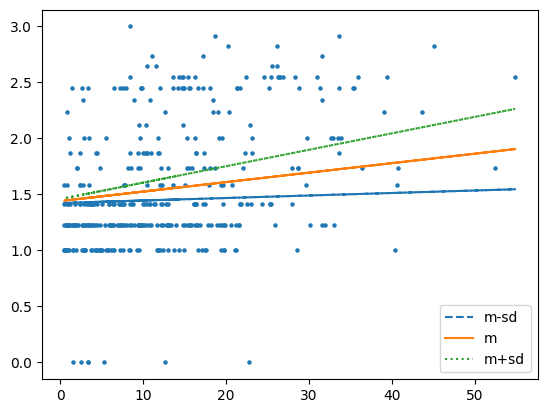

In [43]:
y_lvls = moderation_y(data, res.params, "dzdur", "lesion_vol_logtrans")
plot_moderation(data['dzdur'], data['edss_sqrt'], y_lvls)

In [ ]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ lesion_vol_cubic + PRL + tiv + age + Female", data=data
)

res = outcome_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              edss_sqrt   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     18.96
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           2.94e-19
Time:                        14:24:44   Log-Likelihood:                -271.93
No. Observations:                 376   AIC:                             557.9
Df Residuals:                     369   BIC:                             585.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## Ordinal Regression on EDSS

In [37]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [88]:
mod_prob = OrderedModel.from_formula("EDSS ~ lesion_vol_logtrans_cent*dzdur_cent + tiv + age + Female",
                                     data=data, distr='probit')
res_prob = mod_prob.fit(method='powell')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 2.162230
         Iterations: 10
         Function evaluations: 2428


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   EDSS   Log-Likelihood:                -813.00
Model:                   OrderedModel   AIC:                             1672.
Method:            Maximum Likelihood   BIC:                             1762.
Date:                Mon, 17 Feb 2025                                         
Time:                        21:09:14                                         
No. Observations:                 376                                         
Df Residuals:                     353                                         
Df Model:                           6                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
lesion_vol_logtrans_cent                0.4510      0.139      3.234      0.001       0.178       0.724
dzdur_cent                              0.0159      0.007      2.277      0.023       0.002       0.030
lesion_vol_logtrans_cent:dzdur_cent     0.0295      0.013      2.282      0.022       0.004       0.055
tiv                                    -0.0001      0.000     -0.280      0.780      -0.001       0.001
age                                     0.0273      0.006      4.868      0.000       0.016       0.038
Female                                 -0.1118      0.151     -0.738      0.460      -0.408       0.185
0.0/1.0                                -1.3157      0.883     -1.490      0.136      -3.046       0.415
1.0/1.5                                 0.2515      0.129      1.948      0.051      -0.002       0.505
1.5/2.0                                -0.1330      0.089     -1.495      0.135      -0.307       0.041
2.0/2.5                                -0.7678      0.121     -6.331      0.000      -1.006      -0.530
2.5/3.0                                -1.7727      0.217     -8.179      0.000      -2.198      -1.348
3.0/3.5                                -1.6326      0.206     -7.933      0.000      -2.036      -1.229
3.5/4.0                                -1.7002      0.222     -7.655      0.000      -2.135      -1.265
4.0/4.5                                -1.7724      0.243     -7.308      0.000      -2.248      -1.297
4.5/5.0                                -3.0997      0.496     -6.254      0.000      -4.071      -2.128
5.0/5.5                                -2.5026      0.372     -6.723      0.000      -3.232      -1.773
5.5/6.0                                -2.7873      0.442     -6.305      0.000      -3.654      -1.921
6.0/6.5                                -0.7286      0.171     -4.253      0.000      -1.064      -0.393
6.5/7.0                                -0.6053      0.216     -2.804      0.005      -1.028      -0.182
7.0/7.5                                -1.6395      0.487     -3.365      0.001      -2.594      -0.685
7.5/8.0                                -1.5549      0.562     -2.766      0.006      -2.657      -0.453
8.0/8.5                                -1.1230      0.556     -2.019      0.043      -2.213      -0.033
8.5/9.0                                -0.9786      0.692     -1.414      0.157      -2.335       0.378
=======================================================================================================
"""

In [75]:
data2 = data
data2.loc[:, 'tiv'] = data2['tiv'] / 1000
data2.loc[:, 'choroid_volume'] = data2['choroid_volume'] / 1000

In [86]:
mod_prob = OrderedModel.from_formula("EDSS ~ lesion_vol_logtrans + choroid_volume + tiv + age + Female",
                                     data=data, distr='probit')

res = mod_prob.fit(method='powell')
print(res.summary())

Optimization terminated successfully.
         Current function value: 2.178801
         Iterations: 10
         Function evaluations: 2292
                             OrderedModel Results                             
Dep. Variable:                   EDSS   Log-Likelihood:                -819.23
Model:                   OrderedModel   AIC:                             1682.
Method:            Maximum Likelihood   BIC:                             1769.
Date:                Mon, 17 Feb 2025                                         
Time:                        21:08:16                                         
No. Observations:                 376                                         
Df Residuals:                     354                                         
Df Model:                           5                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

In [89]:
mod_prob = OrderedModel(data['EDSS'], data_z[['lesion_vol_logtrans', 'choroid_volume', 'tiv', 'age', 'Female']])
res = mod_prob.fit(method='powell')
print(res.summary())

Optimization terminated successfully.
         Current function value: 2.178465
         Iterations: 5
         Function evaluations: 1106
                             OrderedModel Results                             
Dep. Variable:                   EDSS   Log-Likelihood:                -819.10
Model:                   OrderedModel   AIC:                             1682.
Method:            Maximum Likelihood   BIC:                             1769.
Date:                Mon, 17 Feb 2025                                         
Time:                        21:10:08                                         
No. Observations:                 376                                         
Df Residuals:                     354                                         
Df Model:                           5                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

In [108]:
# mod_prob = OrderedModel.from_formula("EDSS ~ lesion_vol_logtrans + choroid_volume + tiv + age + Female",
#                                      data=data, distr='probit', hasconst=False)

mod_prob = OrderedModel(data['EDSS'], data[['lesion_vol_logtrans', 'choroid_volume', 'tiv', 'age', 'Female']])

mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ choroid_volume + age + tiv + Female", data=data, hasconst=False
)

med2 = Mediation(
    mod_prob, mediator_model, "choroid_volume", "lesion_vol_logtrans"
).fit()
med2.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/stats/mediation.py:373: RuntimeWarning: divide by zero encountered in divide
  self.prop_med_ctrl = self.ACME_ctrl / self.total_effect
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/stats/mediation.py:373: RuntimeWarning: invalid value encountered in divide
  self.prop_med_ctrl = self.ACME_ctrl / self.total_effect
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/stats/mediation.py:374: RuntimeWarning: divide b

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [115]:
from statsmodels.stats import mediation

mediation._pvalue(med2.ACME_ctrl)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [118]:
med2.ACME_ctrl.shape

(376, 1000)

## MSSS and ARMSS

In [262]:
outcome_model = sm.OLS.from_formula(
    "msss_sqrt ~ choroid_volume + tiv + Female + dzdur", data=data
)

res = outcome_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              msss_sqrt   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     5.973
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           0.000115
Time:                        23:14:08   Log-Likelihood:                -378.00
No. Observations:                 376   AIC:                             766.0
Df Residuals:                     371   BIC:                             785.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5248      0.529      4.

In [263]:
outcome_model = sm.OLS.from_formula(
    "msss_sqrt ~ choroid_volume + lesion_vol_logtrans + dzdur + tiv + Female", data=data
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ choroid_volume + dzdur + tiv + Female", data=data
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "lesion_vol_logtrans"
).fit(method='bootstrap')
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.000104,-0.014373,0.014275,0.978
ACME (treated),0.000104,-0.014373,0.014275,0.978
ADE (control),0.000083,-0.000034,0.000189,0.160
ADE (treated),0.000083,-0.000034,0.000189,0.160
Total effect,0.000187,-0.014320,0.014347,0.970
Prop. mediated (control),0.998700,0.807222,1.259063,0.008
Prop. mediated (treated),0.998700,0.807222,1.259063,0.008
ACME (average),0.000104,-0.014373,0.014275,0.978
ADE (average),0.000083,-0.000034,0.000189,0.160
Prop. mediated (average),0.998700,0.807222,1.259063,0.008


In [239]:
outcome_model = sm.OLS.from_formula(
    "armss_sqrt ~ choroid_volume + lesion_vol_cubic + tiv + Female + age", data=data
)

res = outcome_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             armss_sqrt   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     6.942
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           3.27e-06
Time:                        22:11:57   Log-Likelihood:                -344.81
No. Observations:                 376   AIC:                             701.6
Df Residuals:                     370   BIC:                             725.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.6138      0.509  

In [229]:
outcome_model = sm.OLS.from_formula(
    "armss_sqrt ~ choroid_volume + lesion_vol_logtrans + age + tiv + Female", data=data
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ choroid_volume + age + tiv + Female", data=data
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "lesion_vol_logtrans"
).fit(method='bootstrap')
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.000146,-0.013824,0.014335,0.990
ACME (treated),0.000146,-0.013824,0.014335,0.990
ADE (control),0.000043,-0.000045,0.000130,0.352
ADE (treated),0.000043,-0.000045,0.000130,0.352
Total effect,0.000190,-0.013826,0.014368,0.982
Prop. mediated (control),0.999613,0.885195,1.149866,0.008
Prop. mediated (treated),0.999613,0.885195,1.149866,0.008
ACME (average),0.000146,-0.013824,0.014335,0.990
ADE (average),0.000043,-0.000045,0.000130,0.352
Prop. mediated (average),0.999613,0.885195,1.149866,0.008


In [233]:
mediation_analysis(
    data=data,
    x="choroid_volume",
    m="lesion_vol_logtrans",
    y="armss_sqrt",
    covar=["Female", "age", "tiv"],
    alpha=0.05,
    n_boot=1000,
)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,lesion_vol_logtrans ~ X,0.000231,0.000032,3.327506e-12,0.000168,0.000294,Yes
1,Y ~ lesion_vol_logtrans,0.333021,0.080869,4.714312e-05,0.174002,0.492041,Yes
2,Total,0.000130,0.000054,1.638019e-02,0.000024,0.000237,Yes
3,Direct,0.000061,0.000057,2.841531e-01,-0.000051,0.000173,No
4,Indirect,0.000069,0.000024,0.000000e+00,0.000027,0.000124,Yes


In [244]:
moderation_model = sm.OLS.from_formula(
    "armss_sqrt ~ lesion_vol_logtrans_cent*dzdur_cent + tiv + age + Female", data=data
)

res = moderation_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             armss_sqrt   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     9.882
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           4.08e-10
Time:                        22:12:43   Log-Likelihood:                -333.66
No. Observations:                 376   AIC:                             681.3
Df Residuals:                     369   BIC:                             708.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

-0.41668337909796294


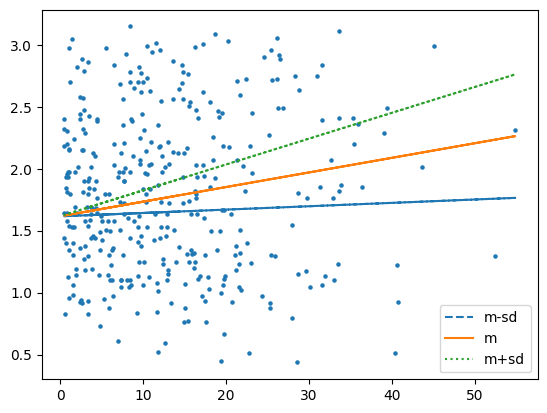

In [245]:
y_lvls = moderation_y(data, res.params, "dzdur_cent", "lesion_vol_logtrans_cent")
plot_moderation(data['dzdur'], data['armss_sqrt'], y_lvls)

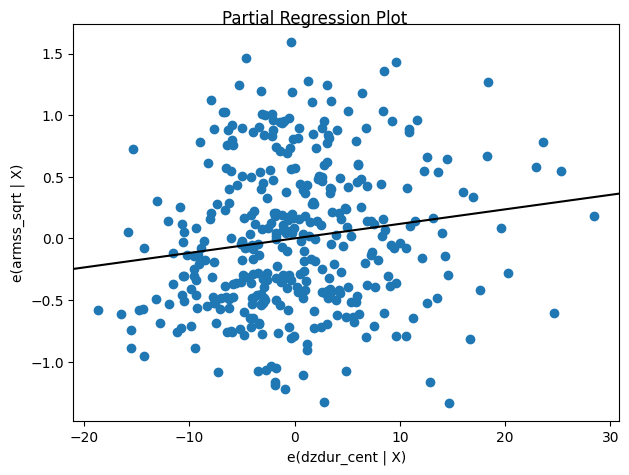

In [246]:
fig = sm.graphics.plot_partregress_grid(res, exog_idx=["dzdur_cent"])

## Predicting PMS vs RMS

Train and test logistic regression on PMS

In [ ]:
model_data = df_z.loc[df_z['dz_type5'].isin(['RMS', 'PMS'])]
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type5'])), axis=1
)
model_data['PMS'] = model_data['PMS'].astype("int64")

train_frac = 0.8
pms_sample = model_data[model_data['dz_type5'] == "PMS"].sample(frac=train_frac)
rms_sample = model_data[model_data['dz_type5'] == "RMS"].sample(frac=train_frac)
train_sample = pd.concat([pms_sample, rms_sample], axis=0)
test_sample = model_data.loc[~model_data.index.isin(train_sample.index)]

predictors = ["choroid_volume", "lesion_vol_cubic", "dzdur", "age", "tiv", "Female", "DMT_hx_all"]
logit_mod = sm.Logit(train_sample['PMS'], train_sample[predictors]).fit()
yhat = logit_mod.predict(test_sample[predictors])
predictions = yhat.round()

tp = sum((predictions == 1) & (test_sample['PMS'] == 1))
tn = sum((predictions == 0) & (test_sample['PMS'] == 0))
fp = sum((predictions == 1) & (test_sample['PMS'] == 0))
fn = sum((predictions == 0) & (test_sample['PMS'] == 1))

(tp + tn) / (fp + fn + tp + tn)

Optimization terminated successfully.
         Current function value: 0.574541
         Iterations 6


0.6463414634146342

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
predictors = ["choroid_volume", "lesion_vol_cubic", "dzdur", "age", "tiv", "Female", "DMT_hx_all"]

model_data = df_z.loc[df_z['dz_type5'].isin(['RMS', 'PMS'])]
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type5'])), axis=1
)
model_data['PMS'] = model_data['PMS'].astype("int64")

X = model_data[predictors]
y = model_data['PMS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
clf = LogisticRegression().fit(X_train, y_train)
clf.score(X_test, y_test)

0.8674698795180723

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

skf = StratifiedKFold(n_splits=5)
log_reg = LogisticRegression()
scores = cross_val_score(
    log_reg, X, y, scoring='accuracy', cv=skf, n_jobs=-1)

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=538541) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=538541) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


In [ ]:
from numpy import mean
from numpy import std
print('Accuracy: %.3f ,\nStandard Deviations :%.3f' %
      (mean(scores), std(scores)))

Accuracy: 0.828 ,
Standard Deviations :0.030


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from numpy import interp

In [ ]:
predictors = ["choroid_volume", "lesion_vol_cubic", "tiv", "DMT_hx_all"]

model_data = df_z.loc[df_z['dz_type5'].isin(['RMS', 'PMS'])]
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type5'])), axis=1
)
model_data['PMS'] = model_data['PMS'].astype("int64")

X = model_data[predictors]
y = model_data['PMS']

X = X.reset_index()
y.index = X.index


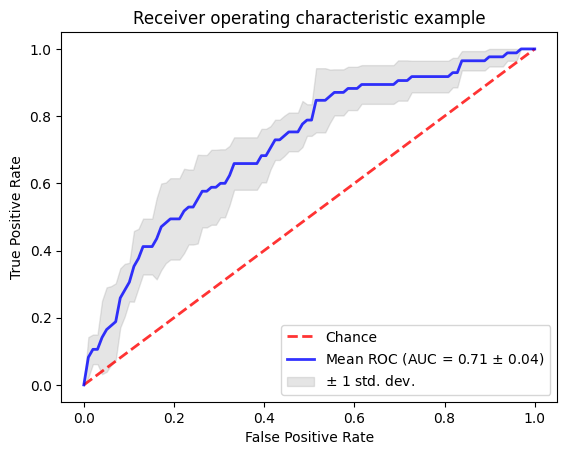

In [ ]:
# random_state = np.random.RandomState(0)
clf = LogisticRegression(max_iter=500)
cv = StratifiedKFold(n_splits=5, shuffle=False)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

clf.predict

i = 0
for train, test in cv.split(X, y):
    probas_ = clf.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    # plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()